# Load multiband raster data via stream API

In [21]:
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.colors as mcolors
import geoengine as ge

## Initialize Geo Engine

In [22]:
ge.initialize("http://localhost:3030/api")

## Define workflow of a stacked raster of ndvi and land cover

In [23]:
workflow = ge.register_workflow({
                "type": "Raster",
                "operator": {
                    "type": "RasterStacker",
                    "params": {},
                    "sources": {
                        "rasters": [
                            {
                                "type": "GdalSource",
                                "params": {
                                    "data": "ndvi"
                                }
                            }, {
                                "type": "GdalSource",
                                "params": {
                                    "data": "land_cover"
                                }
                            }
                        ]
                    }
                }
            })
workflow

3fb85bcc-4b88-5c39-a48e-ac6833d69a8e

## Define a query rectangle

In [24]:
time_start = datetime.strptime('2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
time_end = datetime.strptime('2014-06-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
bbox = ge.QueryRectangle(
    ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
    ge.TimeInterval(time_start, time_end),
    ge.SpatialResolution(0.5, 0.5),
)

# Query single tiles, merge them locally and output them as a single `DataArray`

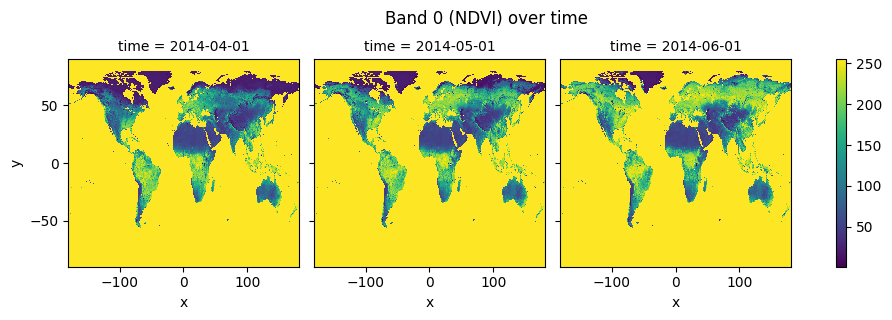

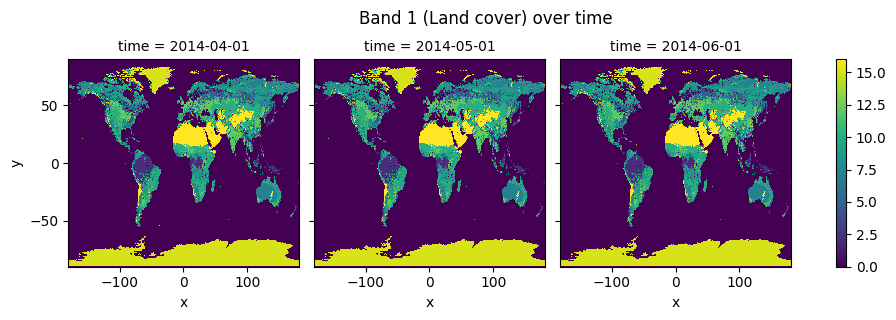

In [25]:
array = await workflow.raster_stream_into_xarray(bbox, bands=[0, 1])

array.isel(band=0).plot(col="time")
plt.suptitle("Band 0 (NDVI) over time", y=1.05)
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.show()

array.isel(band=1).plot(col="time")
plt.suptitle("Band 1 (Land cover) over time", y=1.05)
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.show()


## Output structure of the array

In [26]:
array.to_dataset(name = "Multi-Band")

<xarray.Dataset>
Dimensions:      (x: 1024, y: 1024, time: 3, band: 2)
Coordinates:
  * x            (x) float64 -255.8 -255.2 -254.8 -254.2 ... 254.8 255.2 255.8
  * y            (y) float64 255.8 255.2 254.8 254.2 ... -254.8 -255.2 -255.8
  * time         (time) datetime64[ns] 2014-04-01 2014-05-01 2014-06-01
  * band         (band) int64 0 1
    spatial_ref  int64 0
Data variables:
    Multi-Band   (time, band, y, x) float64 nan nan nan nan ... nan nan nan nan

## Define a multi-band raster as a an RGB composite

In [27]:
workflow = ge.register_workflow({
    "type": "Raster",
    "operator": {
        "type": "RasterStacker",
        "params": {},
        "sources": {
            "rasters": [
                {
                    "type": "GdalSource",
                    "params": {
                        "data": "ne2_raster_red"
                    }
                }, {
                    "type": "GdalSource",
                    "params": {
                        "data": "ne2_raster_green"
                    }
                }, {
                    "type": "GdalSource",
                    "params": {
                        "data": "ne2_raster_blue"
                    }
                }
            ]
        }
    }
})

array = await workflow.raster_stream_into_xarray(bbox, bands=[0, 1, 2])

array.to_dataset(name = "rgb")

<xarray.Dataset>
Dimensions:      (x: 1024, y: 1024, time: 1, band: 3)
Coordinates:
  * x            (x) float64 -255.8 -255.2 -254.8 -254.2 ... 254.8 255.2 255.8
  * y            (y) float64 255.8 255.2 254.8 254.2 ... -254.8 -255.2 -255.8
  * time         (time) datetime64[ns] 2074-06-06T00:21:56.717330432
  * band         (band) int64 0 1 2
    spatial_ref  int64 0
Data variables:
    rgb          (time, band, y, x) float64 nan nan nan nan ... nan nan nan nan

## Plot the bands individually

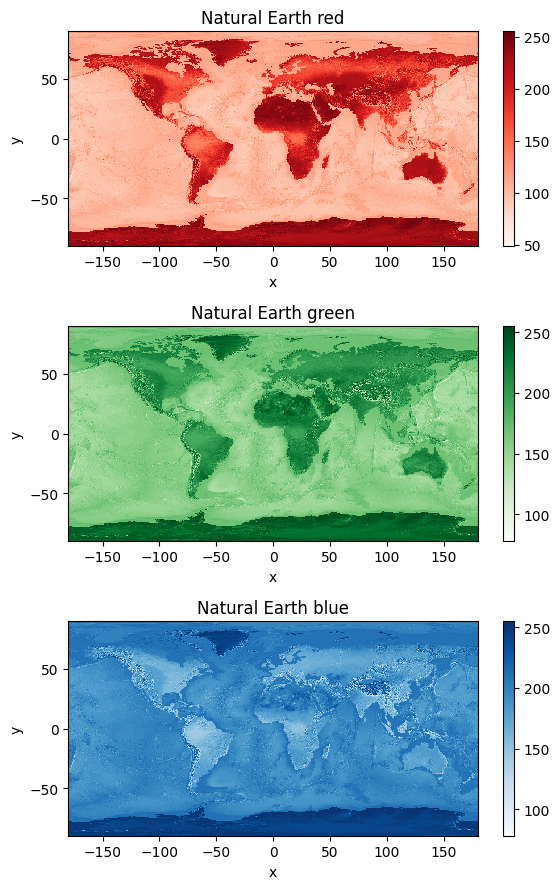

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(6, 9))

cmap = plt.get_cmap('Reds')
norm = mcolors.Normalize(vmin=0, vmax=255)
array.isel(band=0).plot(cmap=cmap, ax=axs[0])
axs[0].set_title("Natural Earth red")
axs[0].set_xlim(-180, 180)
axs[0].set_ylim(-90, 90)

cmap = plt.get_cmap('Greens')
norm = mcolors.Normalize(vmin=0, vmax=255)
array.isel(band=1).plot(cmap=cmap, ax=axs[1])
axs[1].set_title("Natural Earth green")
axs[1].set_xlim(-180, 180)
axs[1].set_ylim(-90, 90)

cmap = plt.get_cmap('Blues')
norm = mcolors.Normalize(vmin=0, vmax=255)
array.isel(band=2).plot(cmap=cmap, ax=axs[2])
axs[2].set_title("Natural Earth blue")
axs[2].set_xlim(-180, 180)
axs[2].set_ylim(-90, 90)

plt.tight_layout()
plt.show()

## Plot the RGB composite

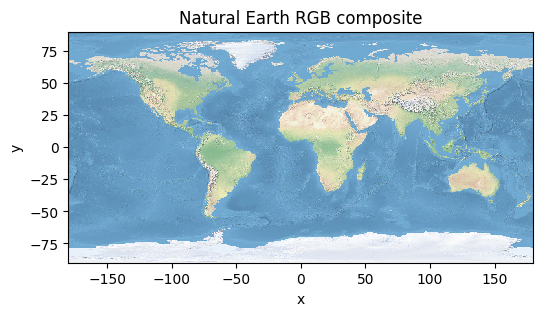

In [29]:
plt.figure(figsize=(6,3))
plt.xlim(-180, 180)
plt.ylim(-90, 90)

array.fillna(0).isel(time=0, drop=True).astype("int").plot.imshow(rgb="band"),

plt.title("Natural Earth RGB composite")
plt.show()
